In [25]:
import pandas as pd
import matplotlib.pyplot as plt
dataset = pd.read_csv('bitcoin_ticker.csv', engine='python', skipfooter=3)
#dataset = dataset[dataset['rpt_key'] == "btc_krw"]['bid']
#dataset.reshape(len(dataset),1)
#plt.plot(dataset)
#plt.show()


           date_id          datetime_id  market  rpt_key       last  \
382562  2017-06-27  2017-06-27 13:36:00  korbit  btc_krw  3164500.0   
382572  2017-06-27  2017-06-27 13:37:00  korbit  btc_krw  3166000.0   
382582  2017-06-27  2017-06-27 13:38:00  korbit  btc_krw  3169000.0   
382592  2017-06-27  2017-06-27 13:39:00  korbit  btc_krw  3158000.0   
382602  2017-06-27  2017-06-27 13:40:00  korbit  btc_krw  3152000.0   
382612  2017-06-27  2017-06-27 13:41:00  korbit  btc_krw  3153000.0   
382622  2017-06-27  2017-06-27 13:42:00  korbit  btc_krw  3157500.0   
382632  2017-06-27  2017-06-27 13:43:00  korbit  btc_krw  3168500.0   
382642  2017-06-27  2017-06-27 13:44:00  korbit  btc_krw  3169000.0   
382652  2017-06-27  2017-06-27 13:45:00  korbit  btc_krw  3170000.0   
382662  2017-06-27  2017-06-27 13:46:00  korbit  btc_krw  3169500.0   
382672  2017-06-27  2017-06-27 13:47:00  korbit  btc_krw  3165500.0   
382682  2017-06-27  2017-06-27 13:48:00  korbit  btc_krw  3169000.0   
382692

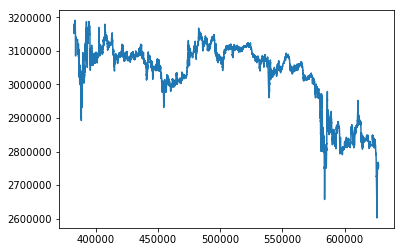

In [26]:
dataset_new = dataset[dataset['date_id']>='2017-06-27']

dataset_new = dataset_new[ dataset_new['rpt_key'] == "btc_krw"]
print dataset_new
plt.plot(dataset_new['bid'])
plt.show()


In [27]:

import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [28]:
# fix random seed for reproducibility
np.random.seed(7)

In [29]:
# load the dataset
dataset = pd.read_csv('bitcoin_ticker.csv', engine='python')
dataset_new = dataset[dataset['date_id']>='2017-06-27']
dataset_new = dataset_new[ dataset_new['rpt_key'] == "btc_krw"]
dataset = dataset_new['bid'].values
dataset = dataset.astype('float32')
dataset = dataset.reshape(len(dataset),1)

In [30]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [31]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

(16390, 8073)


In [34]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)

In [35]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [37]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [38]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(128, input_shape=(1, look_back)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=50, verbose=2)

Epoch 1/10
5s - loss: 0.0588
Epoch 2/10
4s - loss: 0.0012
Epoch 3/10
4s - loss: 9.6681e-04
Epoch 4/10
4s - loss: 7.1952e-04
Epoch 5/10
4s - loss: 4.8149e-04
Epoch 6/10
3s - loss: 2.8211e-04
Epoch 7/10
3s - loss: 1.3995e-04
Epoch 8/10
3s - loss: 6.3094e-05
Epoch 9/10
3s - loss: 3.5157e-05
Epoch 10/10
3s - loss: 2.9181e-05


In [39]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[0,:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[0, :]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 2082.75 RMSE
Test Score: 466.00 RMSE


In [40]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
print trainPredictPlot.shape
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


NameError: name 'numpy' is not defined